In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc
import matplotlib.cm as mmc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()]

In [5]:
def getSFRs(gal, central):
    Idlist, snapst  = [], []
    z, snaplist = [], []
    StarMass = []
    distance = []
    
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    z2, z1 = -1., -1.
    
    z3 = -1.
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

#         Vel = np.sqrt(np.sum((VelGal - VelCen)**2.))*1e3 # in m/s

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

        pos = np.sqrt(np.sum((galPos-groupPos)**2))/r200

        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        
        groupG = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][idd]
        
        if pos<2.:
            z2 = zs
        if pos<1.:
            z1 = zs
        if groupG == group:
            z3 = zs
        
        OffStars = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        mstars = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OffStars[0]:OffStars[1]]
        
        #ok, i thing i got what i need.
        z.append(zs)
        snaplist.append(snap)
        StarMass.append(np.sum(mstars)*1e10)
        distance.append(pos)
        
        # and now lost masses
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)

    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    distance = np.array(distance)
    
    z, snaplist, StarMass = np.array(z), np.array(snaplist), np.array(StarMass)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snapst= snapst[Idunique]
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    snapst_, Idlist_ = snapst[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snapst_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    
    Gas = []
    for s in snaplist:
        k = np.where(snaporder==s)
        GasT = GasMasses[k]
        Gas.append(np.sum(GasT))
    
    Gas = np.array(Gas)
    
    return z, Gas*1e10, StarMass, z1, z2, z3, distance

In [6]:
#let's try this
z, GasMass, StarMass, z1, z2, z3, distance = getSFRs(4338, 4337)

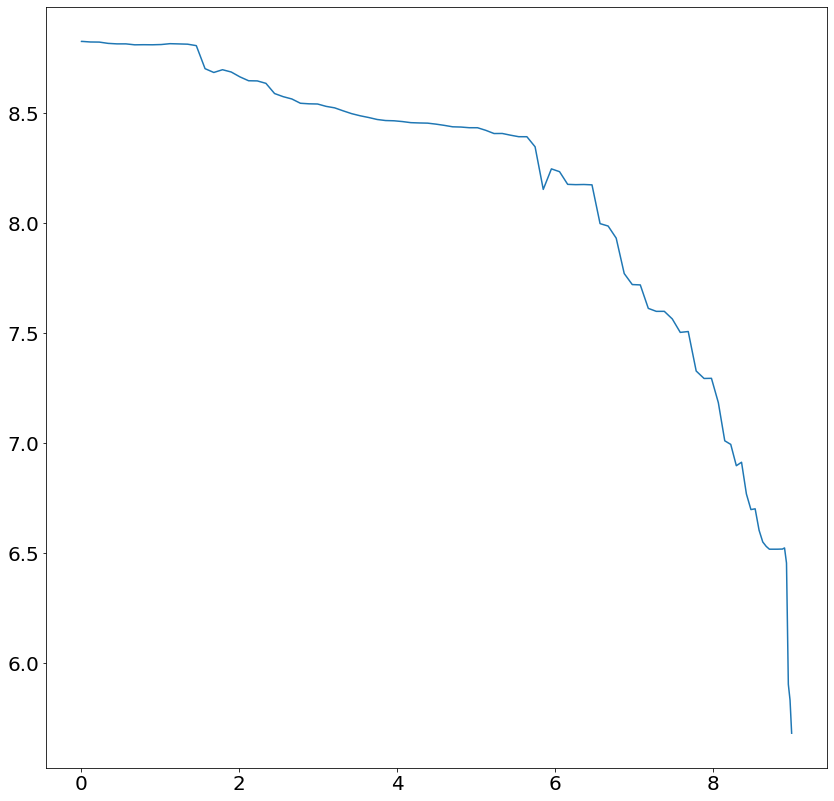

In [7]:
# ok, lets calculate the value, i need to move the

time = Cosmo.lookback_time(z).value

pl.figure(figsize=(14,14))

pl.plot(time, np.log10(StarMass))

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


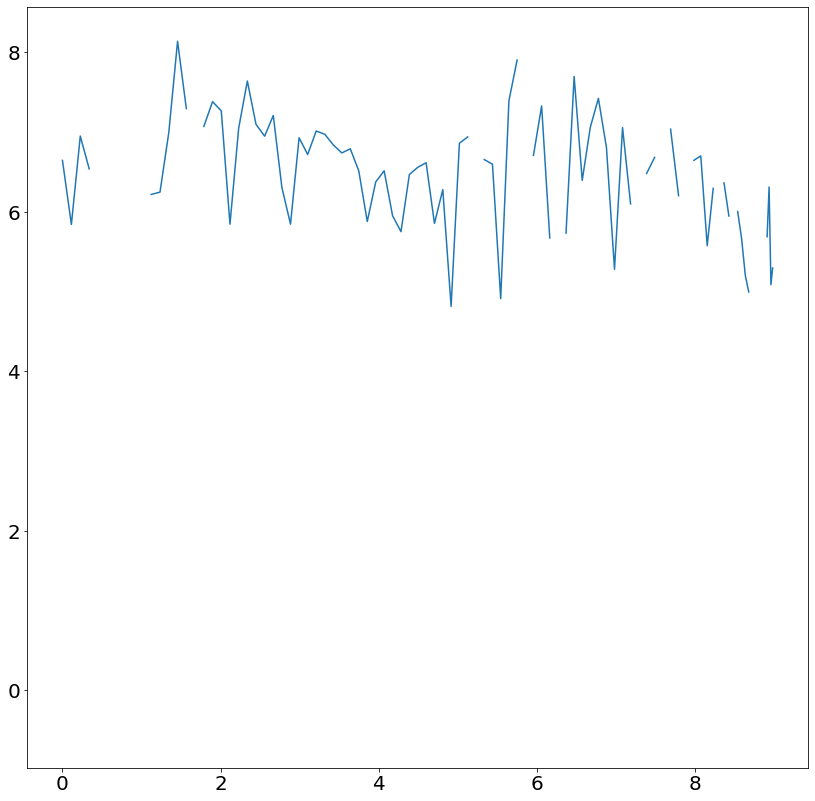

In [8]:
# so, now i going to move things to where they belong (after the mass if formed/detached)

DeltaSTMass = StarMass[:-1] - StarMass[1:]
i = np.where(DeltaSTMass<0)
DeltaSTMass[i] = 0.

pl.figure(figsize=(14,14))

pl.plot(time[:-1], np.log10(DeltaSTMass))

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


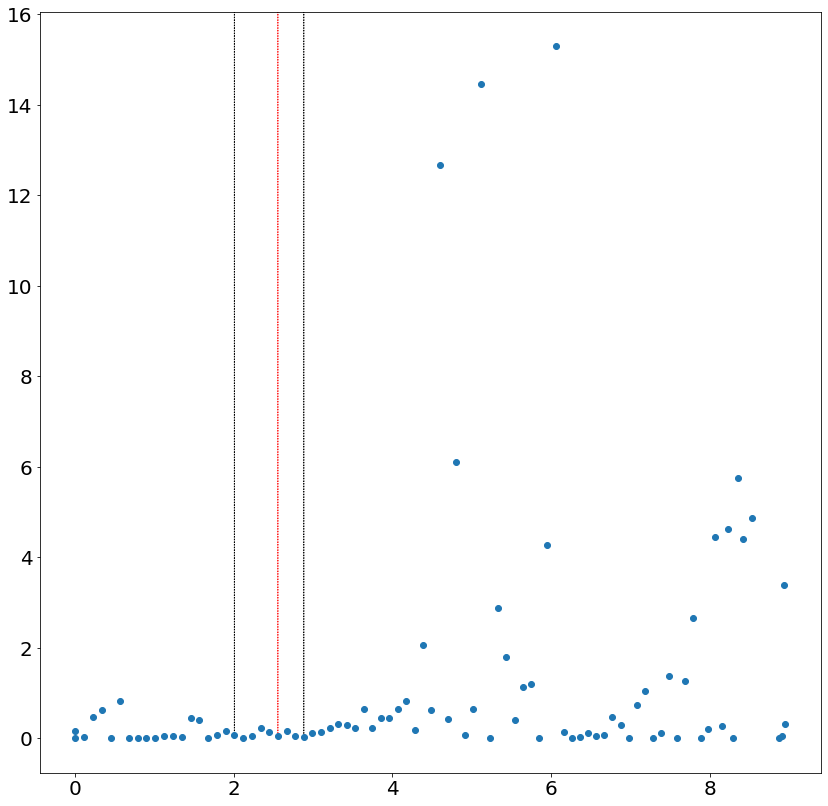

In [9]:
# and the mass difference:
GasMassT = GasMass[1:]


t1, t2 = Cosmo.lookback_time(z1).value, Cosmo.lookback_time(z2).value
Star2Gas = DeltaSTMass/GasMassT

t3 = Cosmo.lookback_time(z3).value

pl.figure(figsize=(14,14))

pl.plot(time[:-1], Star2Gas, marker='o', ls=' ')
pl.arrow(t1, 0, 0 , 100, ls=':', color='black')
pl.arrow(t2, 0, 0 , 100, ls=':', color='black')
pl.arrow(t3, 0, 0 , 100, ls=':', color='red')

In [10]:
# well, i got one.lets try will all of them, i dont know where to cut, buet firts let see.
Slist = h5py.File('SatelliteList_V2_withAngles_n500_KoK04_PairsV2.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]
inPairs = Slist['inGroup']
Mu = Slist['Mu']

In [11]:
Times, SGratio, t1s, t2s, t3s = [], [], [], [], []
Distance = []

bar = progressbar.ProgressBar(max_value=Satellites.size)
I = 0
for S, C in zip(Satellites, Centrals):
    z, GasMass, StarMass, z1, z2, z3, distance = getSFRs(S, C)
    time = Cosmo.lookback_time(z).value
    DeltaSTMass = StarMass[:-1] - StarMass[1:]
    i = np.where(DeltaSTMass<0)
    DeltaSTMass[i] = 0.
    GasMassT = GasMass[1:]

    try:
        t1 = Cosmo.lookback_time(z1).value
    except ZeroDivisionError:
        t1 = -1.
        
    try:
        t2 = Cosmo.lookback_time(z2).value
    except ZeroDivisionError:
        t2 = -1.
        
    try:
        t3 = Cosmo.lookback_time(z3).value
    except ZeroDivisionError:
        t3 = -1
    
    Star2Gas = DeltaSTMass/GasMassT
    
    Times.append(time[:-1])
    SGratio.append(Star2Gas)
    t1s.append(t1)
    t2s.append(t2)
    t3s.append(t3)
    Distance.append(distance[:-1])
    
    I += 1
    bar.update(I)
    
Times, SGratio, t1s, t2s = np.array(Times), np.array(SGratio), np.array(t1s), np.array(t2s)
t3s, Distance = np.array(t3s), np.array(Distance)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
100% (11 of 11) |########################| Elapsed Time: 0:05:10 ETA:  00:00:00

Text(0, 0.5, 'Mass of star formed/Gas stripped')

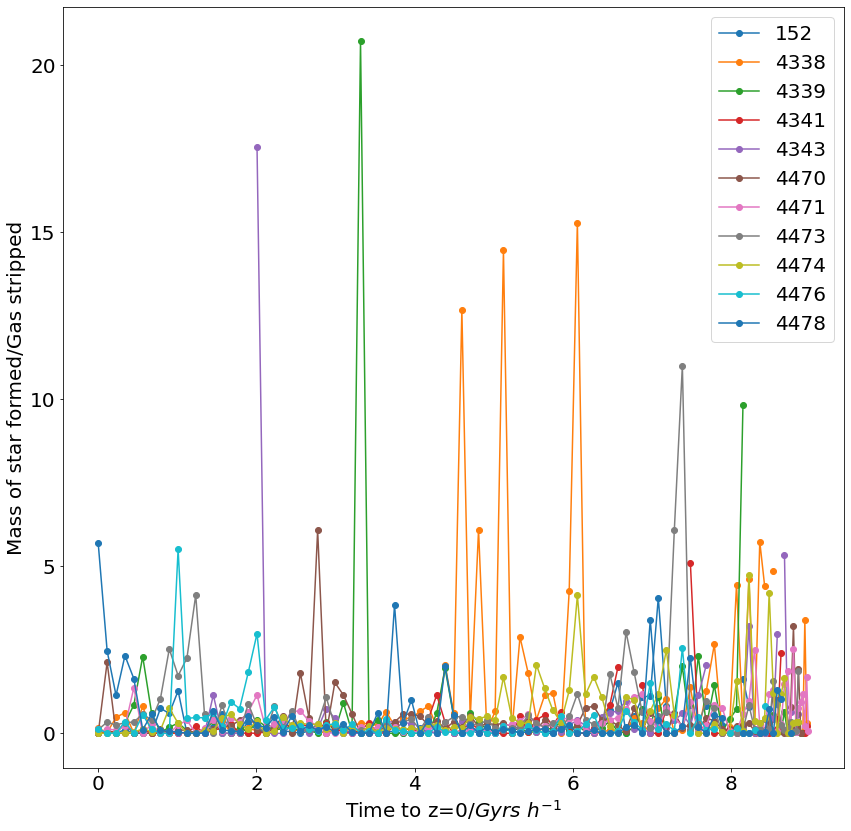

In [12]:
# ok, lets take a look at whats this look like
pl.figure(figsize=(14,14))

for s, t, SG, t1, t2, t3 in zip(Satellites, Times, SGratio, t1s, t2s, t3s):
    pl.plot(t, SG, marker='o', label=s)
    
pl.legend(loc='best')
    
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('Mass of star formed/Gas stripped')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6

Text(0, 0.5, 'Mass of star formed/Gas stripped')

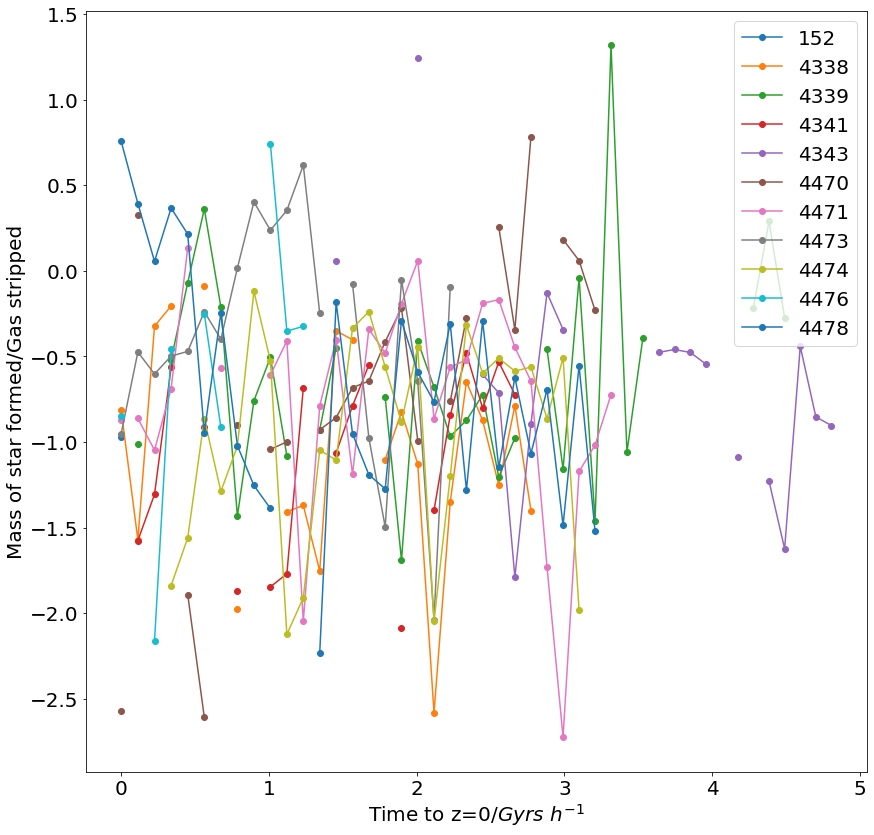

In [13]:
# ok, lets take a look at whats this look like
pl.figure(figsize=(14,14))

for s, t, SG, t1, t2, t3 in zip(Satellites, Times, SGratio, t1s, t2s, t3s):
    ik = np.where(t<t2)
    pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    
pl.legend(loc='best')
    
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('Mass of star formed/Gas stripped')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9

Text(0.5, 0, 'Time to z=0/$Gyrs\\,\\,h^{-1}$')

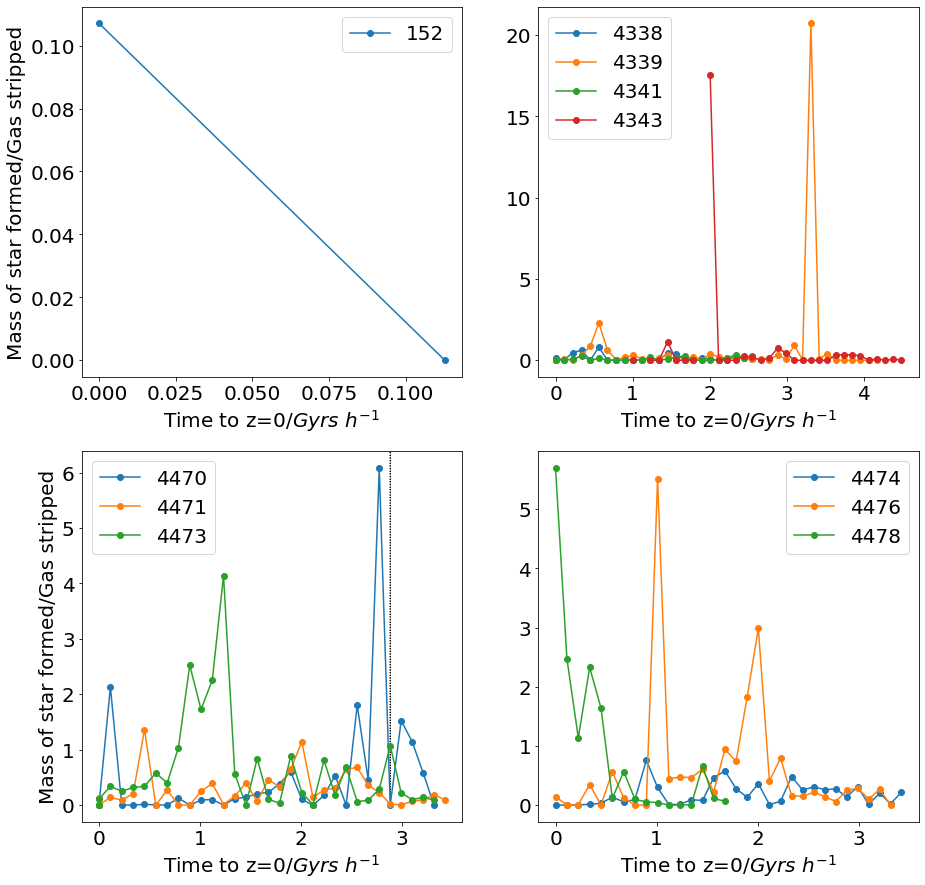

In [14]:
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3 in zip(Satellites, Times, SGratio, Centrals, t1s, t2s, t3s):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
    pl.plot(t[ik], SG[ik], marker='o', label=s)
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('Mass of star formed/Gas stripped')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('Mass of star formed/Gas stripped')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, 0, 0, 100, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using th

Text(0.5, 0, 'distance to centre/$r_{200}$')

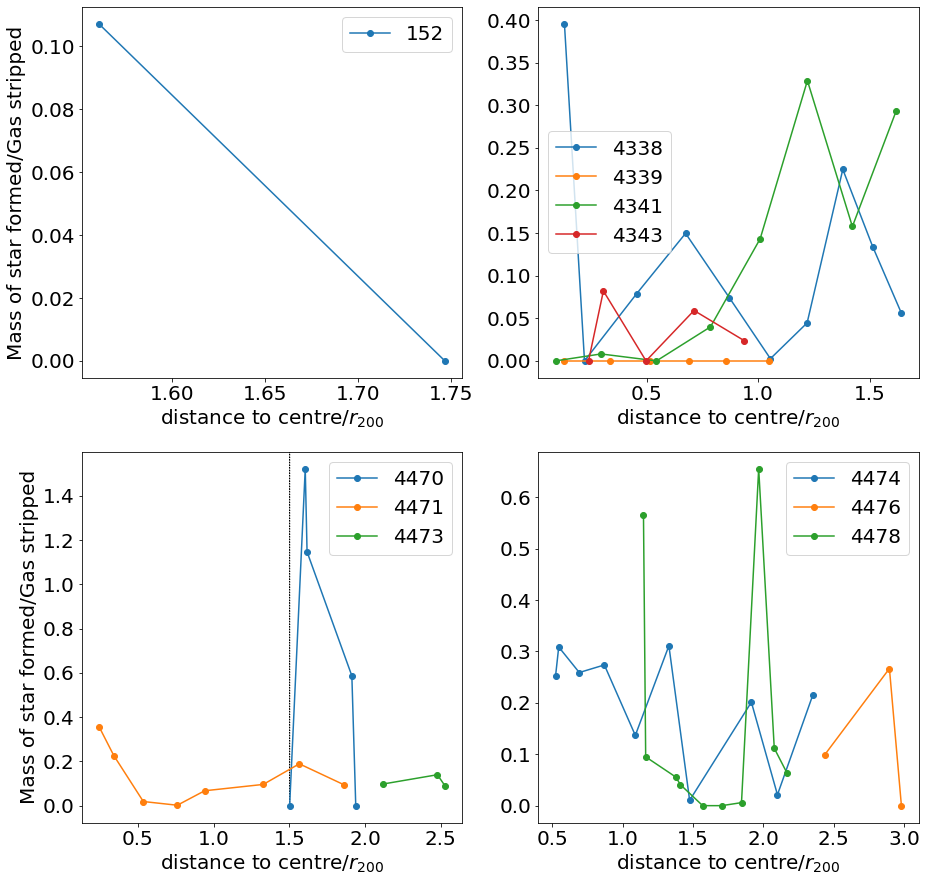

In [15]:
# ok, then distance I guess, but only distances for the "first dive"

# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, distance, c, t1, t2, t3 in zip(Satellites, Times, SGratio, Distance, Centrals, t1s, t2s, t3s):
    ik = np.where(t<=t3)
    distancek = distance[ik]
    tk = t[ik]
    SGK = SG[ik]
    
    # now i have to determine the firts dive
    i = [-1, ]
    old = distancek[-1]

    for j in range(-2, -len(distancek), -1):
        new = distancek[j]
        if new<old:
            i.append(j)
            old = new
        else:
            break

    i = np.array(i)
    
    # i think that do the trick
    distancei = distancek[i]
    ti = tk[i]
    SGi = SGK[i]
    
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
    pl.plot(distancei, SGi, marker='o', label=s)
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')
pl.ylabel('Mass of star formed/Gas stripped')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')
pl.ylabel('Mass of star formed/Gas stripped')
pl.arrow(1.5026178, 0, 0, 100, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')

In [16]:
distance = Distance[1]
t = Times[1]
t3 = t3s[1]

ik = np.where(t<=t3)

distancek = distance[ik]
tk = t[ik]
SGK = SG[ik]

In [17]:
i = [-1, ]
old = distancek[-1]

for j in range(-2, -len(distancek), -1):
    new = distancek[j]
    if new<old:
        i.append(j)
        old = new
    else:
        break
        
i = np.array(i)

In [18]:
i, distancek[i]

(array([ -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10]),
 array([1.64206   , 1.5136758 , 1.3794043 , 1.2194957 , 1.0550331 ,
        0.870849  , 0.6747541 , 0.455761  , 0.22182739, 0.13192993],
       dtype=float32))

In [19]:
distance = Distance[5]
t = Times[5]

np.where(t==tmerger)

(array([27]),)

In [20]:
distance[27]

1.5026178

In [21]:
MassList = np.array([7.69437017, 8.82429688, 8.39572211, 8.23735076, 8.10091713,
       9.5571412 , 9.56148871, 8.58132913, 8.71543015, 8.26700449,
       8.02185292])

In [22]:
AngleList = np.array([0.69231843, 0.84259285, 0.3478571 , 0.59164011, 0.58895167,
       0.36443384, 0.31338675, 0.39019572, 0.67514108, 0.13191934,
       0.43568094])

In [23]:
norm = mpc.Normalize(vmin=MassList.min(),vmax=MassList.max())

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9

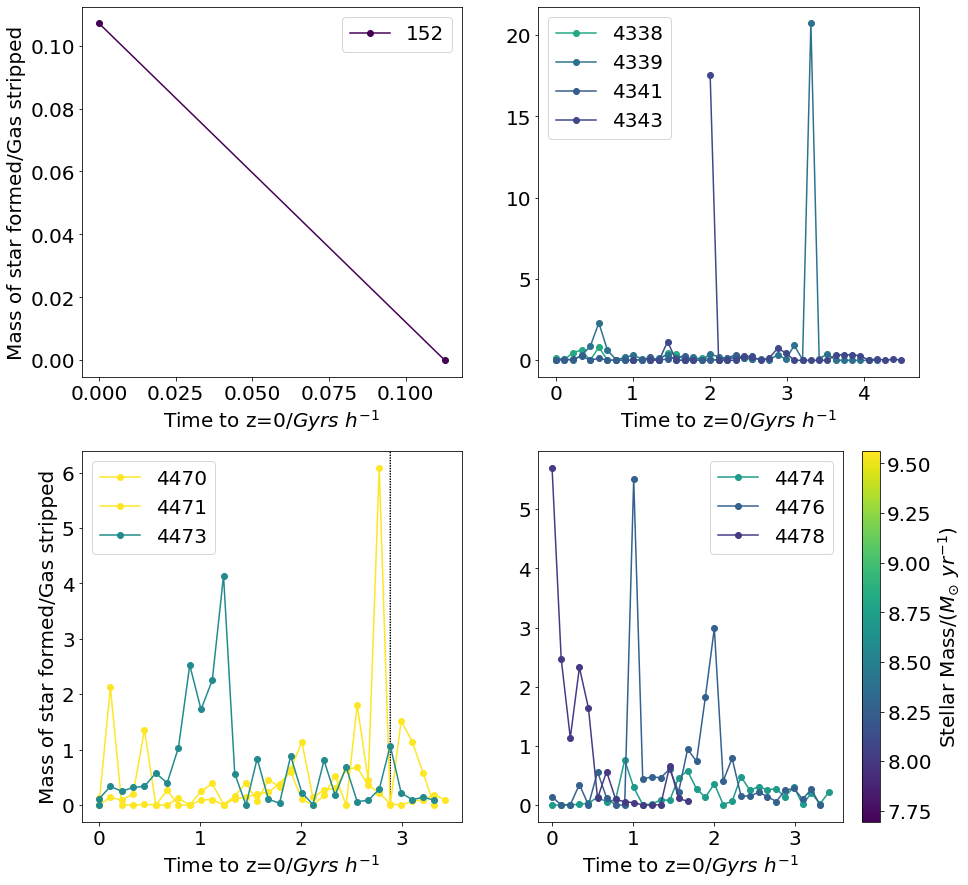

In [24]:
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3, m in zip(Satellites, Times, SGratio, Centrals, t1s, t2s, t3s, MassList):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
    pl.plot(t[ik], SG[ik], marker='o', label=s, color=mmc.viridis(norm(m)))
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('Mass of star formed/Gas stripped')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('Mass of star formed/Gas stripped')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, 0, 0, 100, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

bar = pl.colorbar(mmc.ScalarMappable(norm=norm, cmap=mmc.viridis))
bar.set_label('Stellar Mass$/(M_{\odot}\,\,yr^{-1})$')

In [25]:
norm = mpc.Normalize(vmin=AngleList.min(),vmax=AngleList.max())

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9

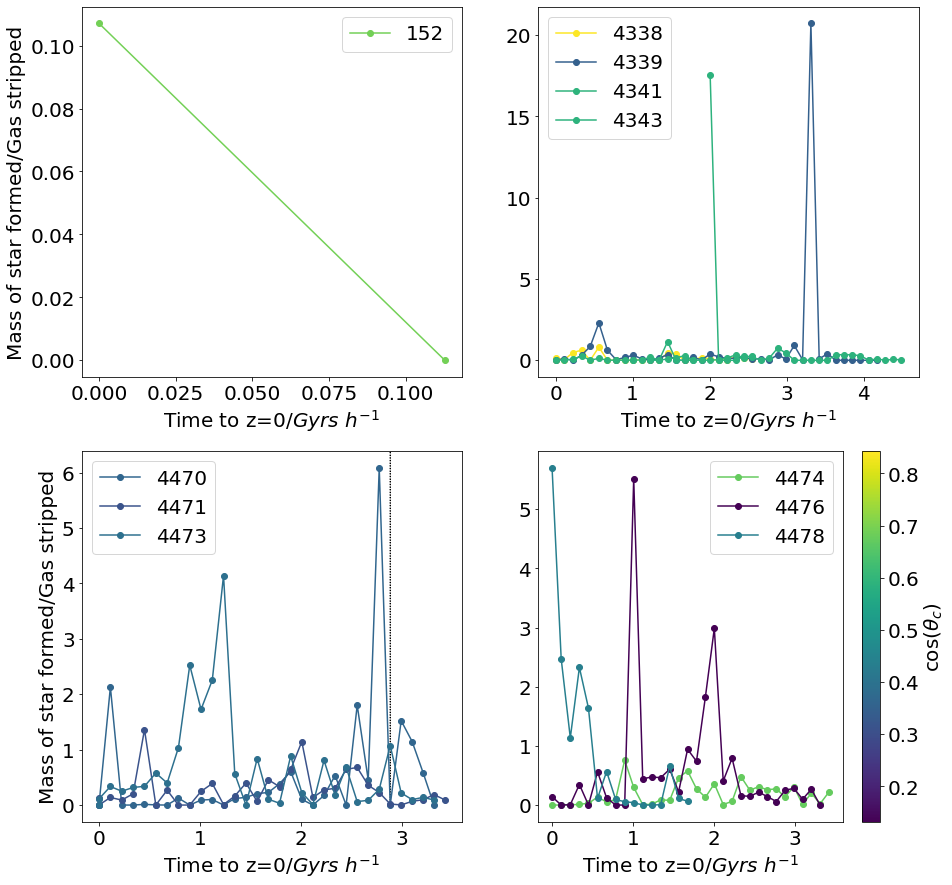

In [26]:
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3, a in zip(Satellites, Times, SGratio, Centrals, t1s, t2s, t3s, AngleList):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
    pl.plot(t[ik], SG[ik], marker='o', label=s, color=mmc.viridis(norm(a)))
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('Mass of star formed/Gas stripped')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('Mass of star formed/Gas stripped')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, 0, 0, 100, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

bar = pl.colorbar(mmc.ScalarMappable(norm=norm, cmap=mmc.viridis))
bar.set_label('cos($\\theta_c$)')

In [27]:
# an improvement to the mass of star formed.
def getSFMass(gal):
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    Alist = []
    
    for m in mtree:
        snap, idd = split_unique_id(int(m))
        at = sim['SnapNumber_{}/Header/Time'.format(snap)][()]
        Alist.append(at)
        
    Alist = np.array(Alist)
    
    SFR, starformed = [], []
    
    I = range(len(mtree))
    
    newZ = []
    for i, m in zip(I[:-1], mtree[:-1]):
        anow = Alist[i]
        athen = Alist[i+1]
        
        snap, idd = split_unique_id(int(m))
        OffStar = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        OffGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        
        Array = np.arange(OffStar[0], OffStar[1])
        
        StarTimes = sim['SnapNumber_{}/PartType4/StellarFormationTime'.format(snap)][OffStar[0]:OffStar[1]]
        inow = np.where((StarTimes<anow) & (StarTimes>=athen))
        Astart = Array[inow]
        
        NewMasses = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][Astart]
        
        SFRt = sim['SnapNumber_{}/PartType0/StarFormationRate'.format(snap)][OffGas[0]:OffGas[1]]
        
        starformed.append(np.sum(NewMasses)*1e10)
        SFR.append(np.sum(SFRt))
        
        newZ.append(sim['SnapNumber_{}/Header/Redshift'.format(snap)][()])

    SFR, starformed = np.array(SFR), np.array(starformed)
    newZ = np.array(newZ)
    
    return SFR, starformed, newZ

In [28]:
# SFR, starformed, newZ = getSFMass(4338)

In [29]:
# pl.figure(figsize=(14,14))

# pl.plot(time, np.log10(starformed))

In [30]:
# again, but well done
Times, SGratio, SFRGratio, t1s, t2s, t3s = [], [], [], [], [], []
Distance = []
GAS, STARS, nSFR = [], [], []


bar = progressbar.ProgressBar(max_value=Satellites.size)
I = 0
for S, C in zip(Satellites, Centrals):
    z, GasMass, StarMass, z1, z2, z3, distance = getSFRs(S, C)
    SFR, starformed, newz = getSFMass(S)
    
    iz = np.isin(newz, z[:-1])
    SFR, starformed = SFR[iz], starformed[iz]
    
    time = Cosmo.lookback_time(z).value
    DeltaSTMass = StarMass[:-1] - StarMass[1:]
    i = np.where(DeltaSTMass<0)
    DeltaSTMass[i] = 0.
    GasMassT = GasMass[1:]

    try:
        t1 = Cosmo.lookback_time(z1).value
    except ZeroDivisionError:
        t1 = -1.
        
    try:
        t2 = Cosmo.lookback_time(z2).value
    except ZeroDivisionError:
        t2 = -1.
        
    try:
        t3 = Cosmo.lookback_time(z3).value
    except ZeroDivisionError:
        t3 = -1
    
    Star2Gas = starformed/GasMassT
    SFR2Gas = SFR/GasMassT
    
    Times.append(time[:-1])
    SGratio.append(Star2Gas)
    t1s.append(t1)
    t2s.append(t2)
    t3s.append(t3)
    Distance.append(distance[:-1])
    SFRGratio.append(SFR2Gas)
    
    GAS.append(GasMassT)
    STARS.append(starformed)
    nSFR.append(SFR)
    
    I += 1
    bar.update(I)
    
Times, SGratio, t1s, t2s = np.array(Times), np.array(SGratio), np.array(t1s), np.array(t2s)
t3s, Distance = np.array(t3s), np.array(Distance)
SFRGratio = np.array(SFRGratio)

GAS, STARS, nSFR = np.array(GAS), np.array(STARS), np.array(nSFR)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
100% (11 of 11) |########################| Elapsed Time: 0:05:22 ETA:  00:00:00

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez

Text(0.5, 0, 'Time to z=0/$Gyrs\\,\\,h^{-1}$')

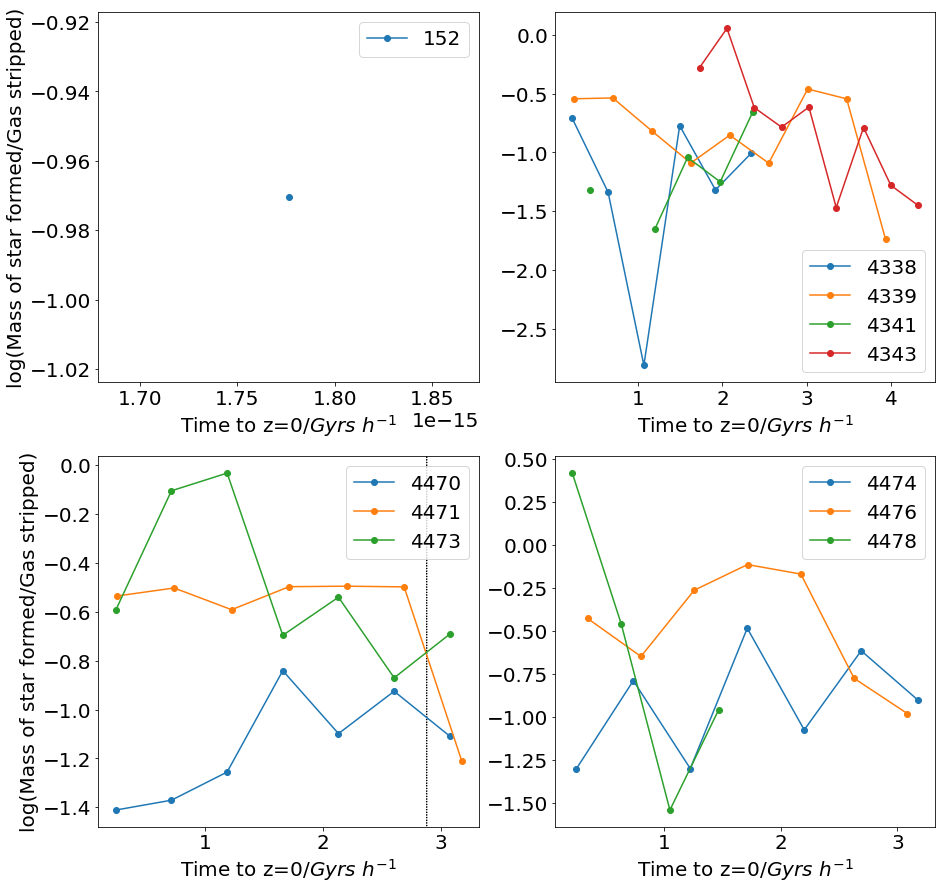

In [31]:
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3 in zip(Satellites, Times, SGratio, Centrals, t1s, t2s, t3s):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
        
    nbin = int(t[ik].size/5)+1
    tt, SGt = t[ik], np.log10(SG[ik])
    ii = np.where((np.isnan(SGt)==False) & (np.isinf(SGt)==False))
    
    dat, binn, inv = sp.binned_statistic(tt[ii], SGt[ii], bins=nbin)
    xs = .5*(binn[:-1]+binn[1:])
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    pl.plot(xs, dat, marker='o', label=s)
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, -100, 0, 200, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/

Text(0.5, 0, 'distance to centre/$r_{200}$')

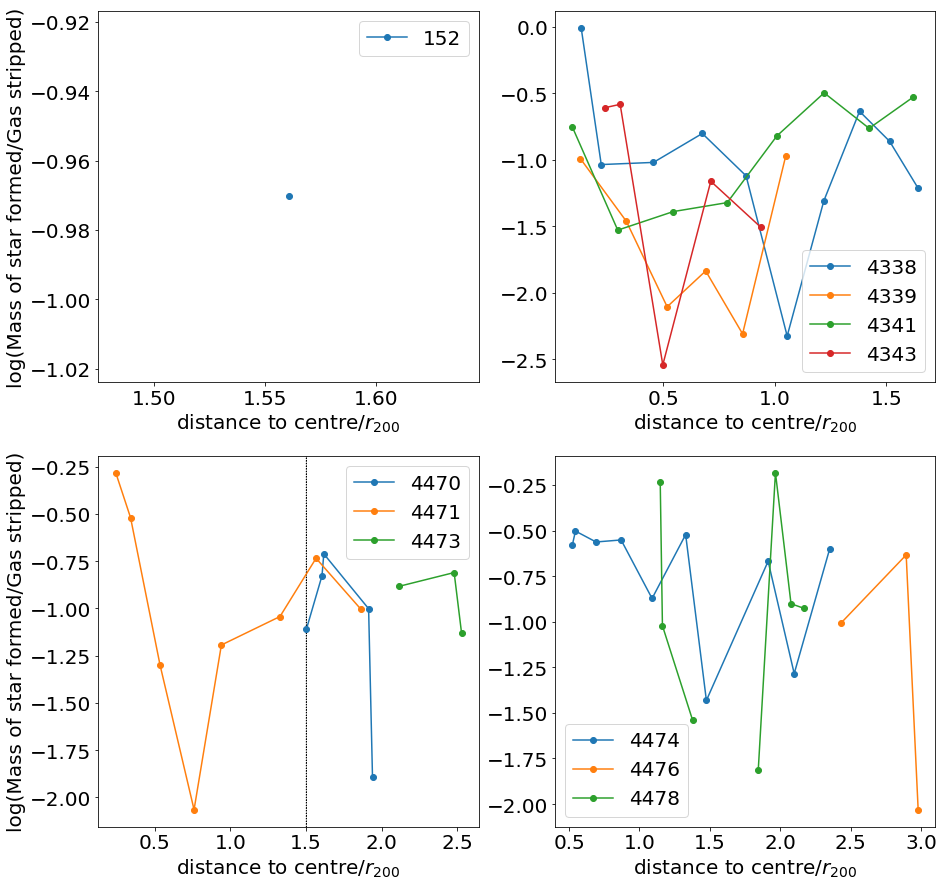

In [32]:
# ok, then distance I guess, but only distances for the "first dive"

# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, distance, c, t1, t2, t3 in zip(Satellites, Times, SGratio, Distance, Centrals, t1s, t2s, t3s):
    ik = np.where(t<=t3)
    distancek = distance[ik]
    tk = t[ik]
    SGK = SG[ik]
    
    # now i have to determine the firts dive
    i = [-1, ]
    old = distancek[-1]

    for j in range(-2, -len(distancek), -1):
        new = distancek[j]
        if new<old:
            i.append(j)
            old = new
        else:
            break

    i = np.array(i)
    
    # i think that do the trick
    distancei = distancek[i]
    ti = tk[i]
    SGi = SGK[i]
    
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
    pl.plot(distancei, np.log10(SGi), marker='o', label=s)
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')
pl.arrow(1.5026178, -100, 0, 200, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')

In [33]:
norm = mpc.Normalize(vmin=MassList.min(),vmax=MassList.max())

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.p

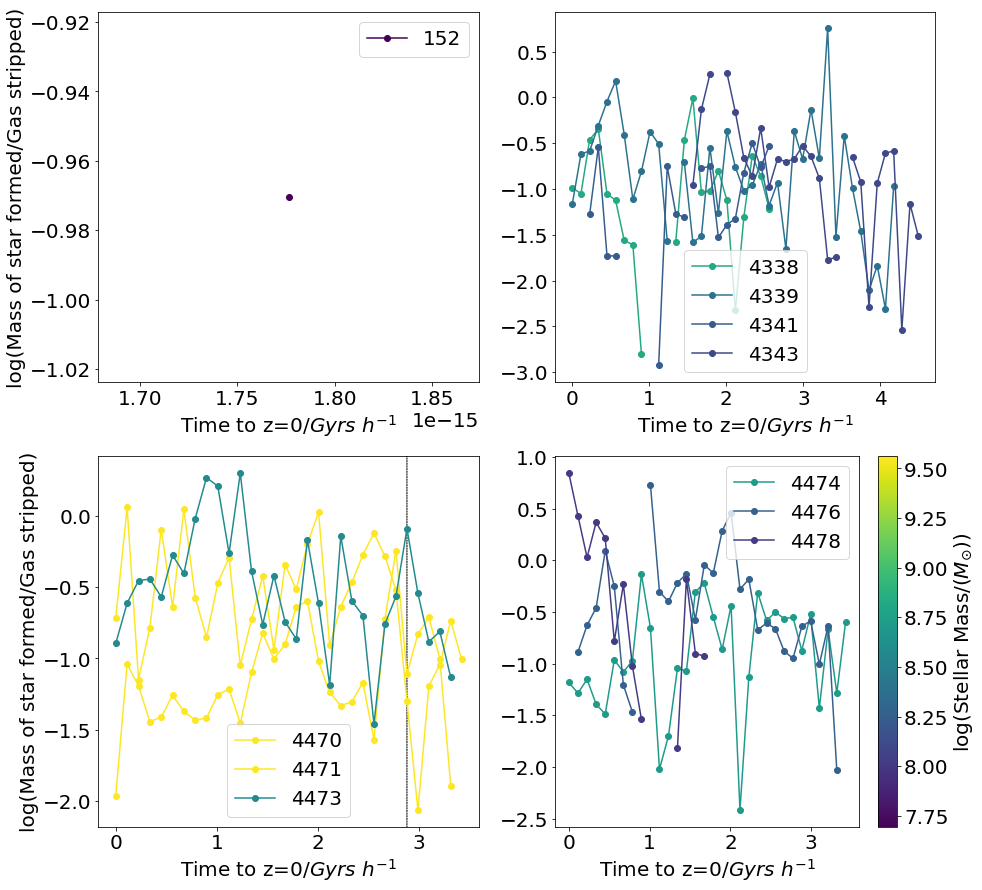

In [34]:
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3, m in zip(Satellites, Times, SGratio, Centrals, t1s, t2s, t3s, MassList):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
    pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s, color=mmc.viridis(norm(m)))
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, -100, 0., 200, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

bar = pl.colorbar(mmc.ScalarMappable(norm=norm, cmap=mmc.viridis))
bar.set_label('log(Stellar Mass$/(M_{\odot})$)')

In [35]:
norm = mpc.Normalize(vmin=AngleList.min(),vmax=AngleList.max())

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.p

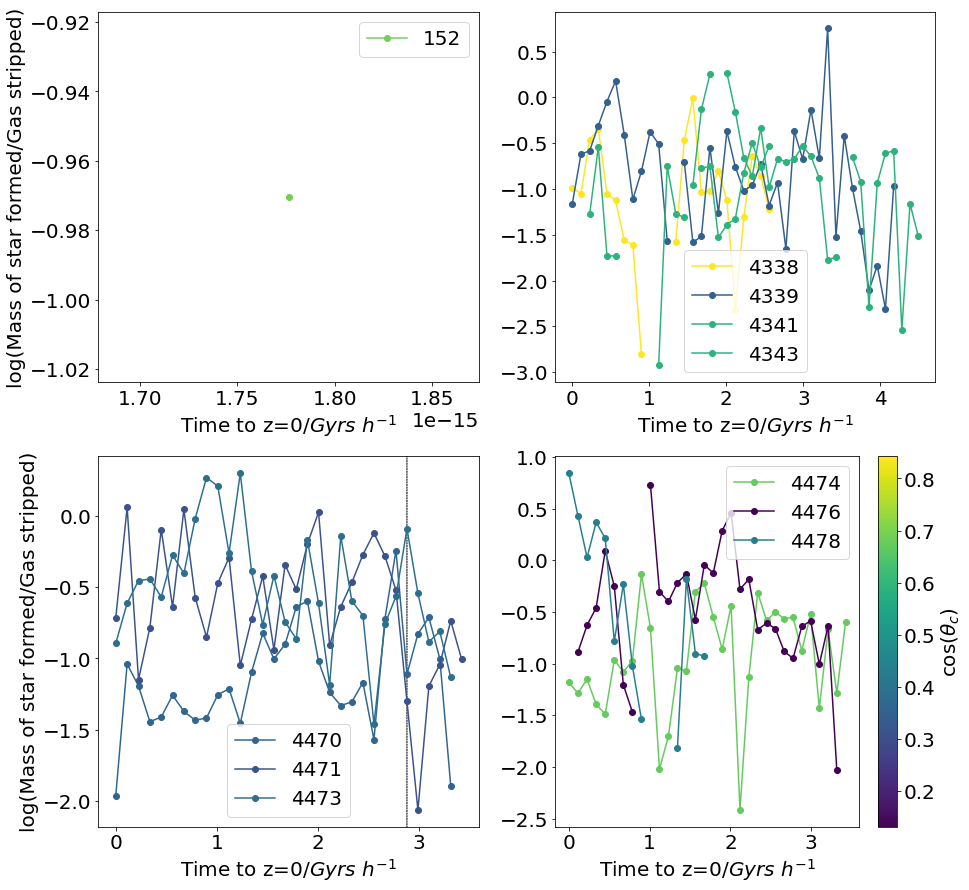

In [36]:
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3, a in zip(Satellites, Times, SGratio, Centrals, t1s, t2s, t3s, AngleList):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
    pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s, color=mmc.viridis(norm(a)))
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, -100, 0, 200, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

bar = pl.colorbar(mmc.ScalarMappable(norm=norm, cmap=mmc.viridis))
bar.set_label('cos($\\theta_c$)')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance

Text(0.5, 0, 'Time to z=0/$Gyrs\\,\\,h^{-1}$')

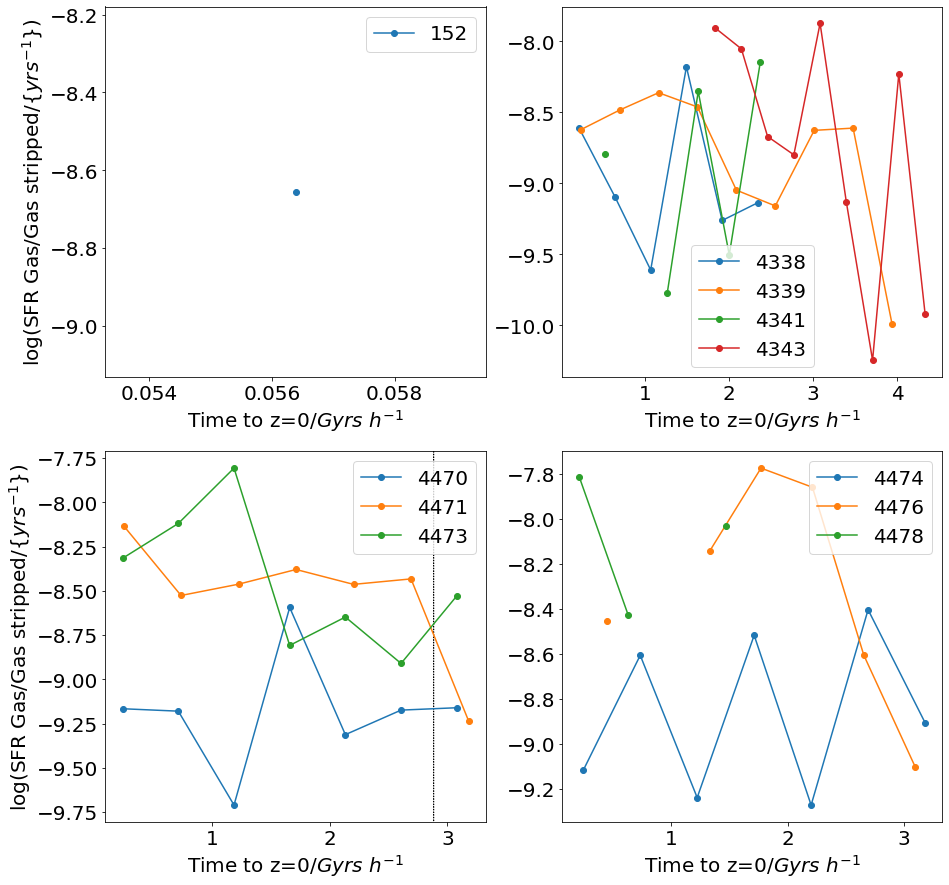

In [37]:
# and the other thing
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3 in zip(Satellites, Times, SFRGratio, Centrals, t1s, t2s, t3s):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
        
    nbin = int(t[ik].size/5)+1
    tt, SGt = t[ik], np.log10(SG[ik])
    ii = np.where((np.isnan(SGt)==False) & (np.isinf(SGt)==False))
    
    dat, binn, inv = sp.binned_statistic(tt[ii], SGt[ii], bins=nbin)
    xs = .5*(binn[:-1]+binn[1:])
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    pl.plot(xs, dat, marker='o', label=s)
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(SFR Gas/Gas stripped/{$yrs^{-1}$})')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')
pl.ylabel('log(SFR Gas/Gas stripped/{$yrs^{-1}$})')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, -100, 0, 200, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/

Text(0.5, 0, 'distance to centre/$r_{200}$')

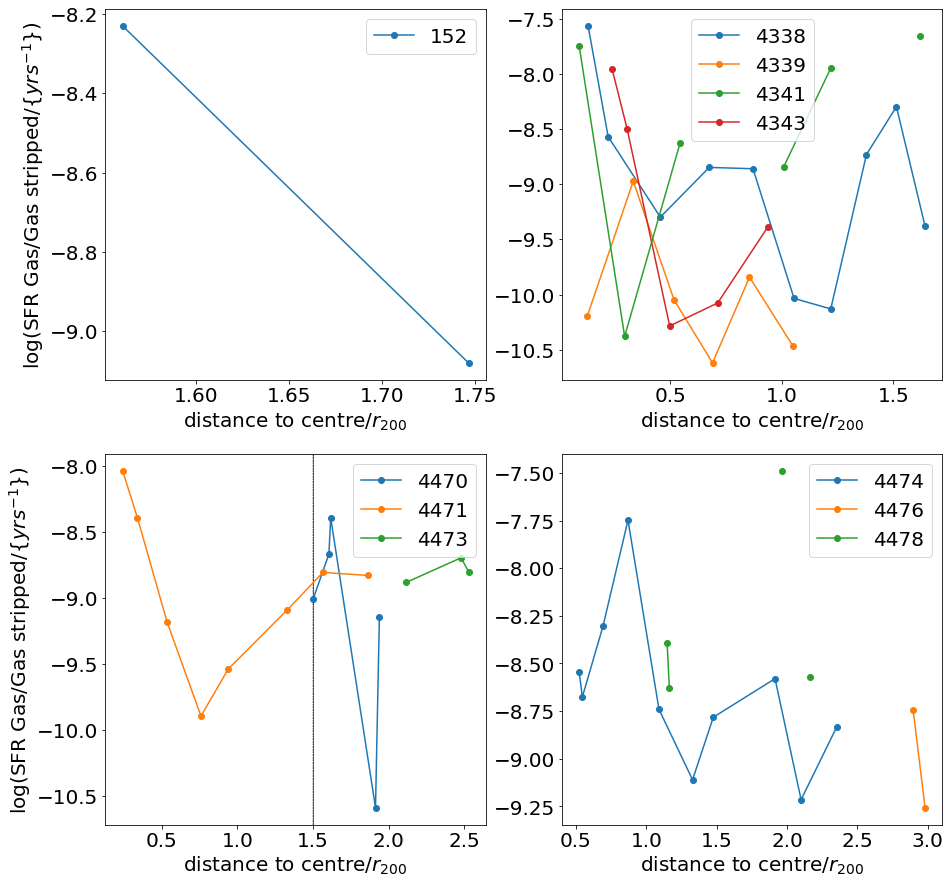

In [38]:
# ok, then distance I guess, but only distances for the "first dive"

# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, distance, c, t1, t2, t3 in zip(Satellites, Times, SFRGratio, Distance, Centrals, t1s, t2s, t3s):
    ik = np.where(t<=t3)
    distancek = distance[ik]
    tk = t[ik]
    SGK = SG[ik]
    
    # now i have to determine the firts dive
    i = [-1, ]
    old = distancek[-1]

    for j in range(-2, -len(distancek), -1):
        new = distancek[j]
        if new<old:
            i.append(j)
            old = new
        else:
            break

    i = np.array(i)
    
    # i think that do the trick
    distancei = distancek[i]
    ti = tk[i]
    SGi = SGK[i]
    
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
    pl.plot(distancei, np.log10(SGi), marker='o', label=s)
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')
pl.ylabel('log(SFR Gas/Gas stripped/{$yrs^{-1}$})')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')
pl.ylabel('log(SFR Gas/Gas stripped/{$yrs^{-1}$})')
pl.arrow(1.5026178, -100, 0, 200, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('distance to centre/$r_{200}$')

In [39]:
norm = mpc.Normalize(vmin=MassList.min(),vmax=MassList.max())

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versio

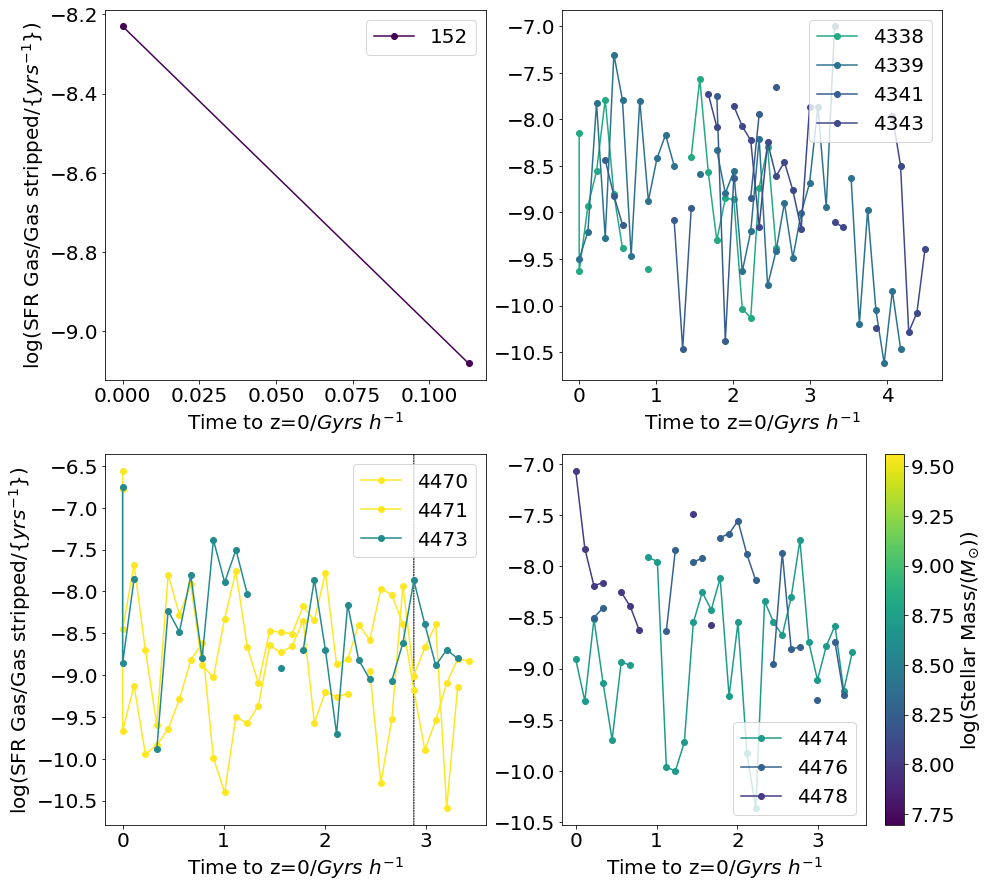

In [40]:
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3, m in zip(Satellites, Times, SFRGratio, Centrals, t1s, t2s, t3s, MassList):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
    pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s, color=mmc.viridis(norm(m)))
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')
pl.ylabel('log(SFR Gas/Gas stripped/{$yrs^{-1}$})')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')
pl.ylabel('log(SFR Gas/Gas stripped/{$yrs^{-1}$})')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, -100, 0., 200, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

bar = pl.colorbar(mmc.ScalarMappable(norm=norm, cmap=mmc.viridis))
bar.set_label('log(Stellar Mass$/(M_{\odot})$)')

In [41]:
norm = mpc.Normalize(vmin=AngleList.min(),vmax=AngleList.max())

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versio

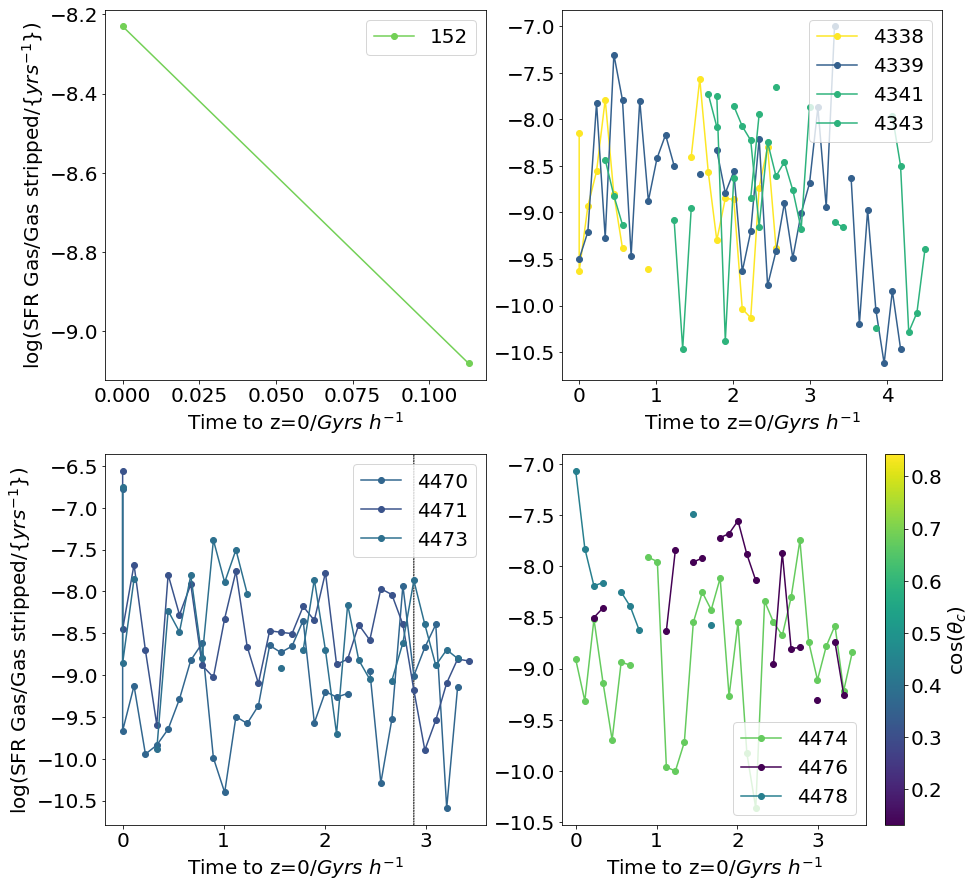

In [42]:
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3, a in zip(Satellites, Times, SFRGratio, Centrals, t1s, t2s, t3s, AngleList):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
    pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s, color=mmc.viridis(norm(a)))
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')
pl.ylabel('log(SFR Gas/Gas stripped/{$yrs^{-1}$})')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Mass of star formed/Gas stripped)')
pl.ylabel('log(SFR Gas/Gas stripped/{$yrs^{-1}$})')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, -100, 0, 200, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

bar = pl.colorbar(mmc.ScalarMappable(norm=norm, cmap=mmc.viridis))
bar.set_label('cos($\\theta_c$)')

In [43]:
sim['SnapNumber_128/SubGroups/OpticalRadius'].attrs['description_units']

'$h^{-1} ckpc$'

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance

Text(0.5, 0, 'Time to z=0/$Gyrs\\,\\,h^{-1}$')

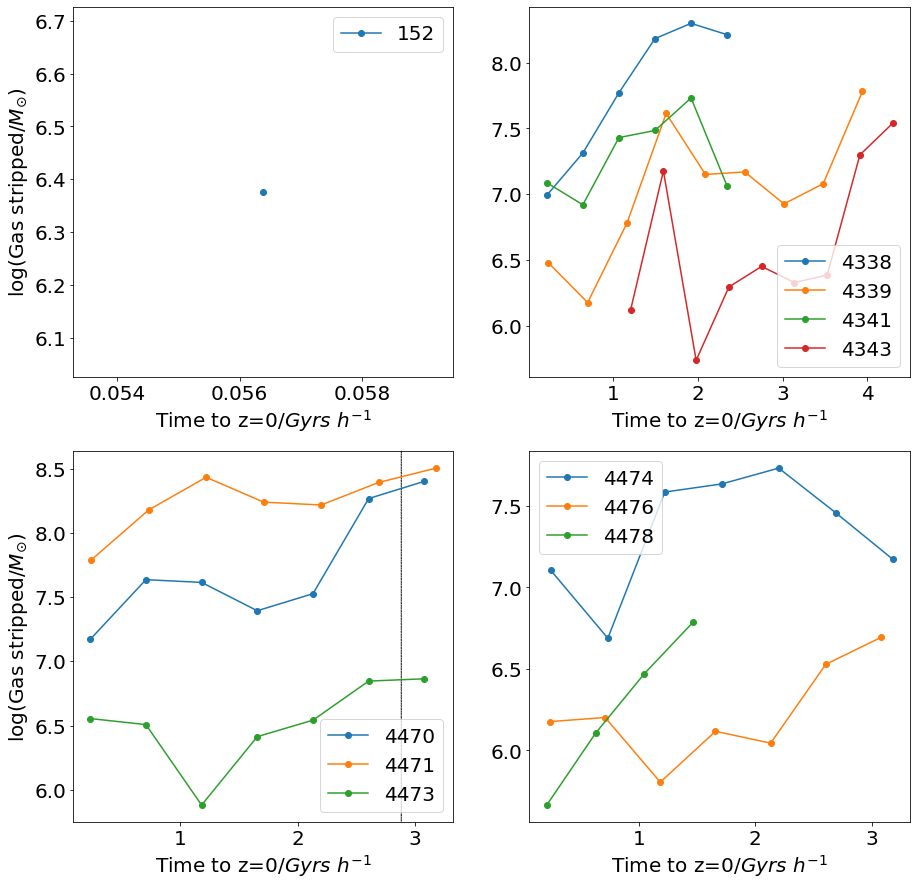

In [44]:
# and the other thing
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3 in zip(Satellites, Times, GAS, Centrals, t1s, t2s, t3s):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
        
    nbin = int(t[ik].size/5)+1
    tt, SGt = t[ik], np.log10(SG[ik])
    ii = np.where((np.isnan(SGt)==False) & (np.isinf(SGt)==False))
    
    dat, binn, inv = sp.binned_statistic(tt[ii], SGt[ii], bins=nbin)
    xs = .5*(binn[:-1]+binn[1:])
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    pl.plot(xs, dat, marker='o', label=s)
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Gas stripped$/M_{\odot}$)')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Gas stripped$/M_{\odot}$)')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, -100, 0, 200, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipy

Text(0.5, 0, 'Time to z=0/$Gyrs\\,\\,h^{-1}$')

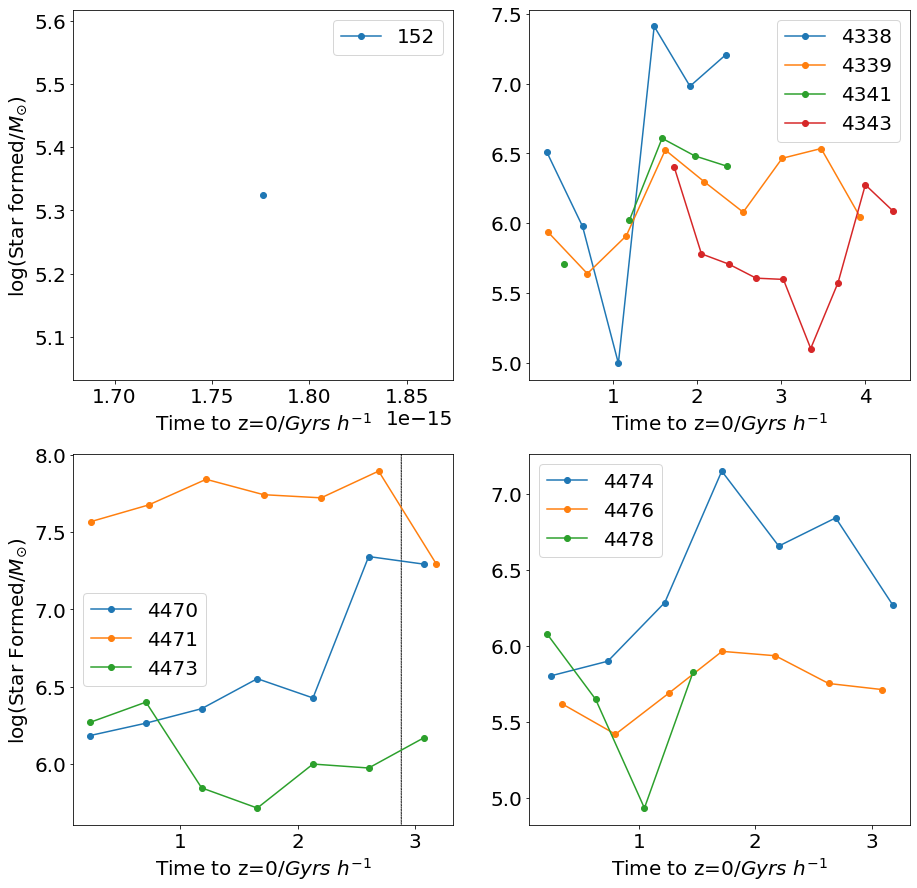

In [45]:
# and the other thing
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3 in zip(Satellites, Times, STARS, Centrals, t1s, t2s, t3s):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
        
    nbin = int(t[ik].size/5)+1
    tt, SGt = t[ik], np.log10(SG[ik])
    ii = np.where((np.isnan(SGt)==False) & (np.isinf(SGt)==False))
    
    dat, binn, inv = sp.binned_statistic(tt[ii], SGt[ii], bins=nbin)
    xs = .5*(binn[:-1]+binn[1:])
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    pl.plot(xs, dat, marker='o', label=s)
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Star formed$/M_{\odot}$)')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(Star Formed$/M_{\odot}$)')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, -100, 0, 200, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance

Text(0.5, 0, 'Time to z=0/$Gyrs\\,\\,h^{-1}$')

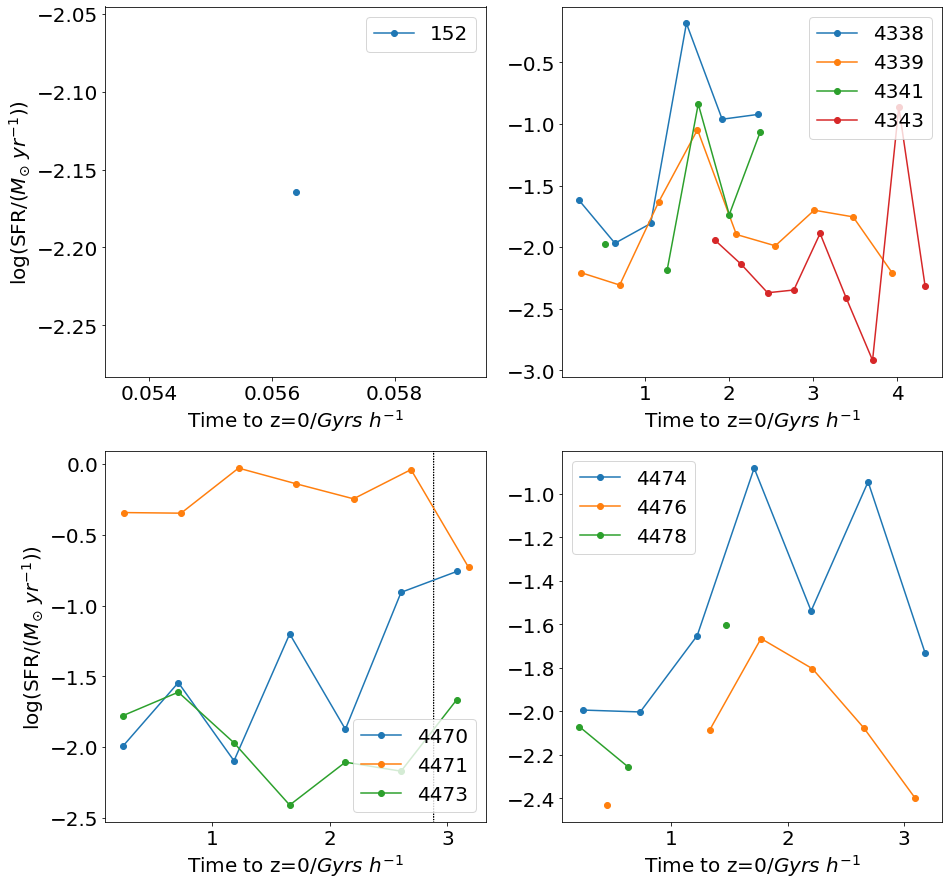

In [46]:
# and the other thing
# ok, lets take a look at whats this look like
pl.figure(figsize=(15, 15))

for s, t, SG, c, t1, t2, t3 in zip(Satellites, Times, nSFR, Centrals, t1s, t2s, t3s):
    ik = np.where(t<=t3)
    if c==151:
        pl.subplot(2, 2 ,1)
    elif c==4337:
        pl.subplot(2, 2, 2)
    elif c==4469 and s<4474:
        pl.subplot(2, 2, 3)
    else:
        pl.subplot(2, 2, 4)
        
    nbin = int(t[ik].size/5)+1
    tt, SGt = t[ik], np.log10(SG[ik])
    ii = np.where((np.isnan(SGt)==False) & (np.isinf(SGt)==False))
    
    dat, binn, inv = sp.binned_statistic(tt[ii], SGt[ii], bins=nbin)
    xs = .5*(binn[:-1]+binn[1:])
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    pl.plot(xs, dat, marker='o', label=s)
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    
pl.subplot(2, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(SFR$/(M_{\odot}\,\,yr^{-1})$)')

pl.subplot(2, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

pl.subplot(2, 2, 3)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(SFR$/(M_{\odot}\,\,yr^{-1})$)')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, -100, 0, 200, ls=':', color='black')

pl.subplot(2, 2, 4)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

In [50]:
# an improvement to the mass of star formed.
def getSFMassV2(gal):
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    Alist = []
    
    for m in mtree:
        snap, idd = split_unique_id(int(m))
        at = sim['SnapNumber_{}/Header/Time'.format(snap)][()]
        Alist.append(at)
        
    Alist = np.array(Alist)
    
    SFR, SFR_a, starformed = [], [], []
    
    I = range(len(mtree))
    
    newZ = []
    for i, m in zip(I[:-1], mtree[:-1]):
        anow = Alist[i]
        athen = Alist[i+1]
        
        snap, idd = split_unique_id(int(m))
        OffStar = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        OffGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        
        Array = np.arange(OffStar[0], OffStar[1])
        
        StarTimes = sim['SnapNumber_{}/PartType4/StellarFormationTime'.format(snap)][OffStar[0]:OffStar[1]]
        inow = np.where((StarTimes<anow) & (StarTimes>=athen))
        Astart = Array[inow]
        
        NewMasses = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][Astart]
        
        SFRt = sim['SnapNumber_{}/PartType0/StarFormationRate'.format(snap)][OffGas[0]:OffGas[1]]
        PosPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OffGas[0]:OffGas[1]]
        PosGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        OptRad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        
        xTc, yTc, zTc = PosPart[:,0]-PosGal[0], PosPart[:,1]-PosGal[1], PosPart[:,2]-PosGal[2]
        distT = np.sqrt(xTc**2.+yTc**2.+zTc**2.)
        icoun = np.where(distT<=OptRad)[0]
        
        starformed.append(np.sum(NewMasses)*1e10)
        znow, zthen = 1./anow -1., 1./athen-1.
        tnow = Cosmo.lookback_time(znow).value
        tthen = Cosmo.lookback_time(zthen).value
        
        DeltaT = (tthen - tnow)*1e9
        SFR_a.append(np.sum(NewMasses)*1e10/DeltaT)
        
        SFR.append(np.sum(SFRt[icoun]))
        
        newZ.append(sim['SnapNumber_{}/Header/Redshift'.format(snap)][()])

    SFR, starformed, SFR_a = np.array(SFR), np.array(starformed), np.array(SFR_a)
    newZ = np.array(newZ)
    
    return SFR, SFR_a, starformed, newZ

In [51]:
SFR, SFR_a, starformed, newz = getSFMassV2(4338)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


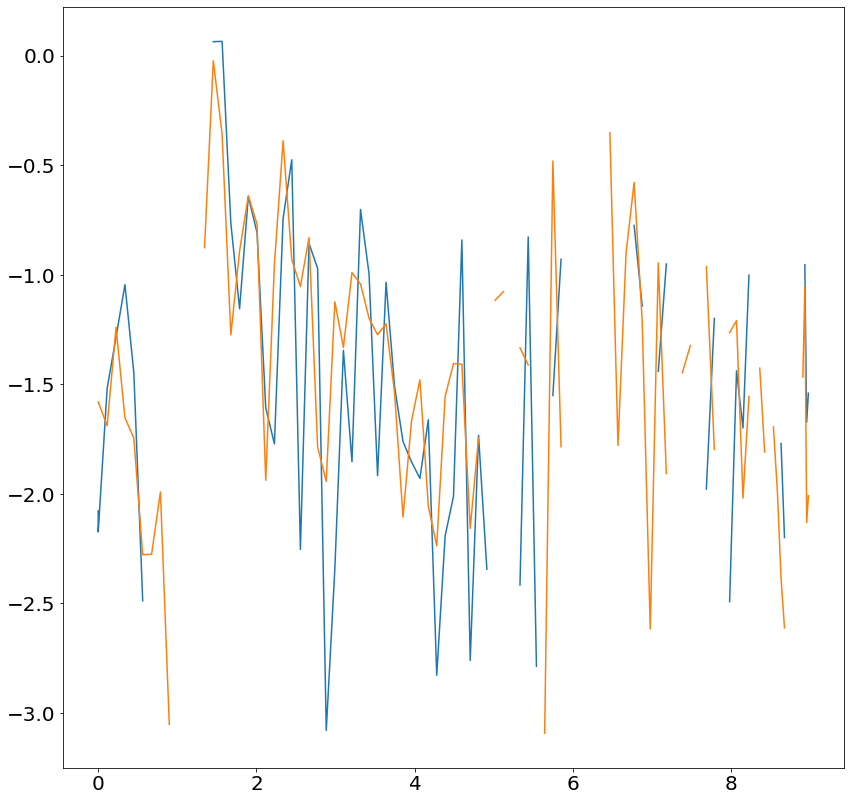

In [52]:
NewTime = Cosmo.lookback_time(newz).value

pl.figure(figsize=(14,14))

pl.plot(NewTime, np.log10(SFR))
pl.plot(NewTime, np.log10(SFR_a))

In [55]:
# Last one
Times, t1s, t2s, t3s = [], [], [], []
GAS, STARS, nSFR, nSFRa = [], [], [], []


bar = progressbar.ProgressBar(max_value=Satellites.size)
I = 0
for S, C in zip(Satellites, Centrals):
    z, GasMass, StarMass, z1, z2, z3, distance = getSFRs(S, C)
    SFR, SFR_a, starformed, newz = getSFMassV2(S)
    
    iz = np.isin(newz, z[:-1])
    SFR, starformed, SFR_a = SFR[iz], starformed[iz], SFR_a[iz]
    
    time = Cosmo.lookback_time(z).value
    DeltaSTMass = StarMass[:-1] - StarMass[1:]
    i = np.where(DeltaSTMass<0)
    DeltaSTMass[i] = 0.
    GasMassT = GasMass[1:]

    try:
        t1 = Cosmo.lookback_time(z1).value
    except ZeroDivisionError:
        t1 = -1.
        
    try:
        t2 = Cosmo.lookback_time(z2).value
    except ZeroDivisionError:
        t2 = -1.
        
    try:
        t3 = Cosmo.lookback_time(z3).value
    except ZeroDivisionError:
        t3 = -1
    
    Star2Gas = starformed/GasMassT
    SFR2Gas = SFR/GasMassT
    
    Times.append(time[:-1])
    t1s.append(t1)
    t2s.append(t2)
    t3s.append(t3)

    GAS.append(GasMassT)
    STARS.append(starformed)
    nSFR.append(SFR)
    nSFRa.append(SFR_a)
    
    I += 1
    bar.update(I)
    
Times, t1s, t2s = np.array(Times), np.array(t1s), np.array(t2s)
t3s = np.array(t3s)
SFRGratio = np.array(SFRGratio)

GAS, STARS, nSFR, nSFRa = np.array(GAS), np.array(STARS), np.array(nSFR),np.array(nSFRa)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less_equal
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
100% (11 of 11) |########################| Elapsed Time: 0:05:40 ETA:  0

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same argume

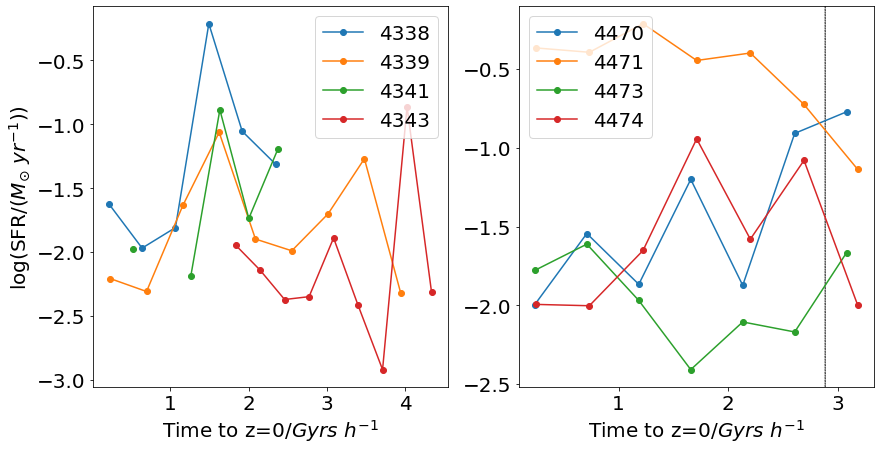

In [56]:
# and the other thing
# ok, lets take a look at whats this look like
pl.figure(figsize=(14, 7))

for s, t, SG, c, t1, t2, t3 in zip(Satellites, Times, nSFR, Centrals, t1s, t2s, t3s):
    ik = np.where(t<=t3)
    if s==152 or s==4476 or s==4478:
        continue
    
    if c==4337:
        pl.subplot(1, 2, 1)
    else:
        pl.subplot(1, 2, 2)
        
    nbin = int(t[ik].size/5)+1
    tt, SGt = t[ik], np.log10(SG[ik])
    ii = np.where((np.isnan(SGt)==False) & (np.isinf(SGt)==False))
    
    dat, binn, inv = sp.binned_statistic(tt[ii], SGt[ii], bins=nbin)
    xs = .5*(binn[:-1]+binn[1:])
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    pl.plot(xs, dat, marker='o', label=s)
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    
pl.subplot(1, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(SFR$/(M_{\odot}\,\,yr^{-1})$)')

pl.subplot(1, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, -100, 0, 200, ls=':', color='black')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same argume

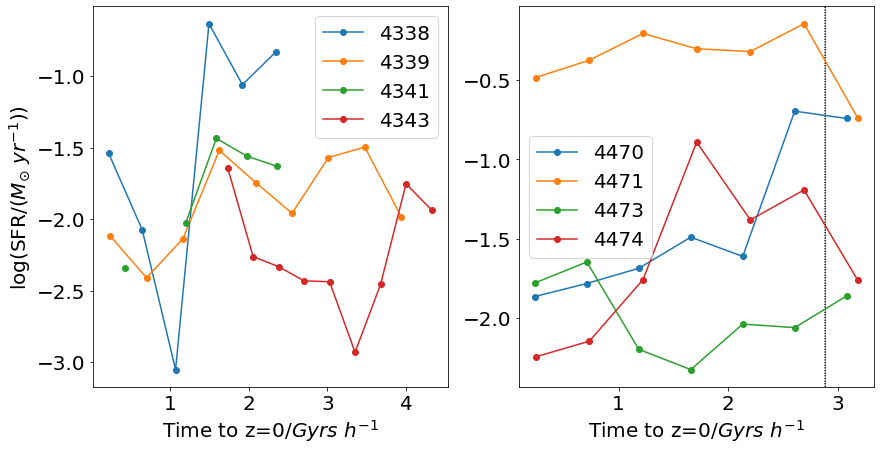

In [57]:
# and the other thing
# ok, lets take a look at whats this look like
pl.figure(figsize=(14, 7))

for s, t, SG, c, t1, t2, t3 in zip(Satellites, Times, nSFRa, Centrals, t1s, t2s, t3s):
    ik = np.where(t<=t3)
    if s==152 or s==4476 or s==4478:
        continue
    
    if c==4337:
        pl.subplot(1, 2, 1)
    else:
        pl.subplot(1, 2, 2)
        
    nbin = int(t[ik].size/5)+1
    tt, SGt = t[ik], np.log10(SG[ik])
    ii = np.where((np.isnan(SGt)==False) & (np.isinf(SGt)==False))
    
    dat, binn, inv = sp.binned_statistic(tt[ii], SGt[ii], bins=nbin)
    xs = .5*(binn[:-1]+binn[1:])
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    pl.plot(xs, dat, marker='o', label=s)
    
#     pl.plot(t[ik], np.log10(SG[ik]), marker='o', label=s)
    
pl.subplot(1, 2, 1)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')
pl.ylabel('log(SFR$/(M_{\odot}\,\,yr^{-1})$)')

pl.subplot(1, 2, 2)
pl.legend(loc='best')
pl.xlabel('Time to z=0/$Gyrs\,\,h^{-1}$')

tmerger = Cosmo.lookback_time(0.38219559019532867).value
pl.arrow(tmerger, -100, 0, 200, ls=':', color='black')